# Notable Notes

All notes are heavily influenced (copied mostly!) from the handouts

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')

## Supervised learning - Regression
Say that you observe $n$, $d$-dimensional, *inputs*:
$$
\mathbf{x}_{1:n} = \{\mathbf{x}_1,\dots,\mathbf{x}_n\},
$$
and *outputs*:
$$
\mathbf{y}_{1:n} = \{y_1,\dots,y_n\}.
$$
The regression problem consits of using the data $\mathbf{x}_{1:n}$ and $\mathbf{y}_{1:n}$ to find
the map that connects the inputs to the outputs.

We will be playing with the following dataset consisting of motorcycle crash data.
Namely, it records the observed head acceleration (in g) at different times (in miliseconds) after the crash.

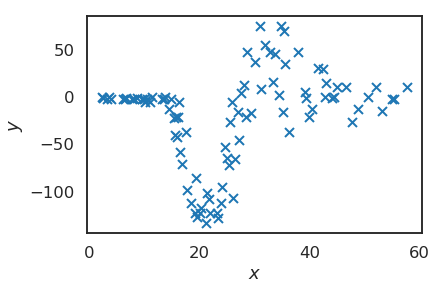

In [2]:
data = np.loadtxt('motor.dat')
X = data[:, 0][:, None]
Y = data[:, 1]
fig, ax = plt.subplots()
ax.plot(X, Y, 'x', markeredgewidth=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

### Regression model
+ Any model that connects $\mathbf{x}$ to $y$ through the use of some parameters.
+ Linear regression:
$$
y(\mathbf{x}; \mathbf{w}) = w_{0} + w_{1}x_{1} + ... + w_{D}x_{D},
$$
+ Generalized linear model:
$$
y(\mathbf{x};\mathbf{w}) = \sum_{j=1}^{m} w_{j}\phi_{j}(\mathbf{x}) = \mathbf{w^{T}\boldsymbol{\phi}(\mathbf{x})}
$$
where $\mathbf{w} = (w_{1}, ... , w_{m})^{T}$ and $\boldsymbol{\phi} = (\phi_{1}, ..., \phi_{m})^{T}$ are arbitrary basis functions.

### Naming conventions
+ $\mathbf{x}$: input
+ $\phi_i(\mathbf{x})$: feature or basis function
+ $y$: output or target

### Generalized linear model
+ Note that the *generalized linear model*:
$$
y(\mathbf{x};\mathbf{w}) = \sum_{j=1}^{m} w_{j}\phi_{j}(\mathbf{x}) = \mathbf{w^{T}\phi(x)},
$$
is linear in $\mathbf{w}$ not $\mathbf{x}$.
+ $\boldsymbol{\phi}(\mathbf{x})$ can be non-linear.

### Examples of generalized linear models:
Remember:
$$
y(x;\mathbf{w}) = \sum_{j=1}^{m} w_{j}\phi_{j}(\mathbf{x}) = \mathbf{w^{T}\phi(x)}.
$$
Some examples of $\phi_j(\mathbf{x})$'s are:
+ Linear, $\phi_j(\mathbf{x}) = x_j$.
+ Polynomials, $\phi_j(x) = \sum_{\alpha\in\mathcal{A}_j}\beta_{\alpha}\mathbf{x}^{\alpha}$.
+ Radial basis function, $\phi_j(x) = \exp\left\{-\frac{\parallel \mathbf{x} - \mathbf{x}_j\parallel^2}{2\ell^2}\right\}$.
+ Fourier series, $\phi_{2j}(x) = \cos\left(\frac{2j\pi}{L}x\right)$ and $\phi_{2j+1}(x)=\sin\left(\frac{2j\pi}{L}x\right)$.
+ $\dots$

# Solution #1, Fitting Using Least Squares

## Fitting GLMs using Least Squares
+ First published by [Legendre](https://en.wikipedia.org/wiki/Adrien-Marie_Legendre) in 1805.
+ The idea is to find the best $\mathbf{w}$ by minimizing a quadratic loss function:
$$
\mathcal{L}(\mathbf{w})\equiv\mathcal{L}(\mathbf{w};\mathbf{x}_{1:n},\mathbf{y}_{1:n}) = \sum_{i=1}^n\left[y(\mathbf{x}_i;\mathbf{w}) - y_i\right]^2.
$$

### Expressing the Loss Function using Matrix-Vector multiplication
+ The loss function can be re-expressed as:
$$
\begin{array}{ccc}
\mathcal{L}(\mathbf{w}) &=& \lVert\boldsymbol{\Phi}\mathbf{w} - \mathbf{y}_{1:n}\rVert^2\\
&=& \left(\boldsymbol{\Phi}\mathbf{w} - \mathbf{y}_{1:n}\right)^T\left(\boldsymbol{\Phi}\mathbf{w} - \mathbf{y}_{1:n}\right).
\end{array}
$$
+ Here $\boldsymbol{\Phi}\in\mathbb{R}^{n\times m}$ is the **design matrix**:
$$
\Phi_{ij} = \phi_j(\mathbf{x}_j).
$$

Let's define some classes to let us play with the concepts from the class. All will be upfront for readability, examples will follow.

In [3]:
# We need a generic function that computes the design matrix
def compute_design_matrix(X, phi):
    """
    Arguments:
    
    X   -  The observed inputs (1D array)
    phi -  The basis functions.
    """
    num_observations = X.shape[0]
    num_basis = phi.num_basis
    Phi = np.ndarray((num_observations, num_basis))
    for i in xrange(num_observations):
        Phi[i, :] = phi(X[i, :])
    return Phi

# Implementation of the basis functions
class LinearBasis(object):
    """
    Represents a 1D linear basis.
    """
    def __init__(self):
        self.num_basis = 2 # The number of basis functions
    def __call__(self, x):
        """
        ``x`` should be a 1D array.
        """
        return [1., x[0]]
    
# Here is a class for the polynomials:
class PolynomialBasis(object):
    """
    A set of linear basis functions.
    
    Arguments:
    degree  -  The degree of the polynomial.
    """
    def __init__(self, degree):
        self.degree = degree
        self.num_basis = degree + 1
    def __call__(self, x):
        return np.array([x[0] ** i for i in range(self.degree + 1)])

# Here is a class for the Fourier basis:
class FourierBasis(object):
    """
    A set of linear basis functions.
    
    Arguments:
    num_terms  -  The number of Fourier terms.
    L          -  The period of the function.
    """
    def __init__(self, num_terms, L):
        self.num_terms = num_terms
        self.L = L
        self.num_basis = 2 * num_terms
    def __call__(self, x):
        res = np.ndarray((self.num_basis,))
        for i in xrange(self.num_terms):
            res[2 * i] = np.cos(2 * i * np.pi / self.L * x[0])
            res[2 * i + 1] = np.sin(2 * (i+1) * np.pi / self.L * x[0])
        return res    
   
# Here is a class for the polynomials:
class RadialBasisFunctions(object):
    """
    A set of linear basis functions.
    
    Arguments:
    X   -  The centers of the radial basis functions.
    ell -  The assumed lengthscale.
    """
    def __init__(self, X, ell):
        self.X = X
        self.ell = ell
        self.num_basis = X.shape[0]
    def __call__(self, x):
        return np.exp(-.5 * (x - self.X) ** 2 / self.ell ** 2).flatten()
    
def perform_and_show_fit(phi, X, Y):
    # Ready to do least squares:
    Phi = compute_design_matrix(X, phi)
    w_LS = np.linalg.lstsq(Phi, Y)[0]
    # Let's plot the result on these points:
    X_p = np.linspace(0, 60, 100)[:, None]
    Phi_p = compute_design_matrix(X_p, phi)
    Y_p = np.dot(Phi_p, w_LS)
    fig, ax = plt.subplots()
    ax.plot(X, Y, 'x', markeredgewidth=2, label='Observations')
    ax.plot(X_p, Y_p, label='LS Prediction (Linear Basis)')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    plt.legend(loc='best')

### Example - Linear Least Squares - Linear Features
We will use two features ($m=2$):
$$
\phi_1(\mathbf{x}) = 1,
$$
and
$$
\phi_2(\mathbf{x}) = x.
$$

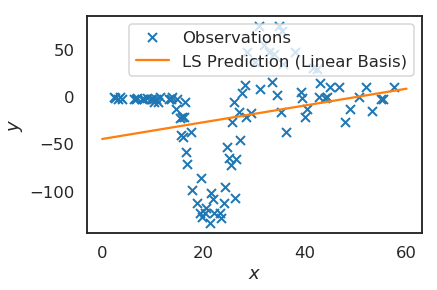

In [4]:
perform_and_show_fit(LinearBasis(), X, Y)

### Let's try Polynomials of Higher Degree

$$
\phi_j(x) = x^{j-1}, j=1,\dots,m
$$

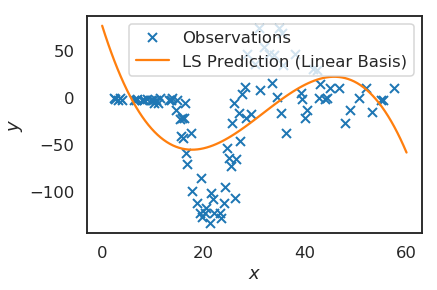

In [5]:
perform_and_show_fit(PolynomialBasis(3), X, Y)

### Let's try a Fourier Basis
$$
\phi_{2j}(x) = \cos\left(\frac{2j\pi}{L}x)\right),
$$
and
$$
\phi_{2j+1}(x) = \sin\left(\frac{2j\pi}{L}x)\right),
$$
for $j=1,\dots,m/2$.

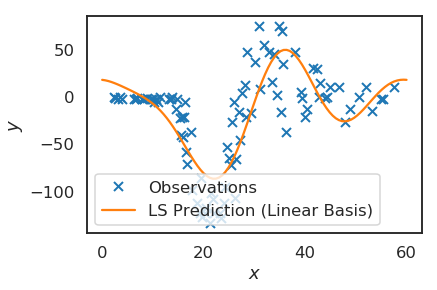

In [6]:
perform_and_show_fit(FourierBasis(3, 60), X, Y)

### Let's try a radial basis function approximation:
$$
\phi_i(x) = \exp\left\{-\frac{(x-x_i^c)^2}{2\ell^2}\right\},
$$
where $x_i^c$ are points about each the basis functions are centered.

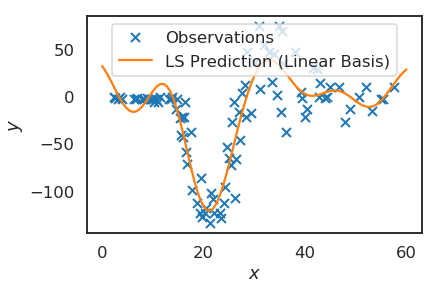

In [7]:
perform_and_show_fit(RadialBasisFunctions(np.linspace(0, 60, 10), 5), X, Y)

### Issues with Least Squares
+ How do I quantify uncertainty due to the measurement noise?
+ How do I quantify uncertainty due to limited data?
+ How many basis functions should I use?
+ Which basis functions should I use?
+ How do I pick the parameters of the basis functions, e.g., the lengthscale $\ell$ of the RBFs?

### The next section will address each of these issues in order, building up to a versitile Bayesian approach that has none of these pitfalls

## Probabilistic Regression - Version 1

+ We wish to model the data using some **fixed** basis/features:
$$
y(\mathbf{x};\mathbf{w}) = \sum_{j=1}^{m} w_{j}\phi_{j}(\mathbf{x}) = \mathbf{w}^T\boldsymbol{\phi}(\mathbf{x})
$$

+ We *model the measurement process* using a **likelihood** function:
$$
\mathbf{y}_{1:n} | \mathbf{x}_{1:n}, \mathbf{w} \sim p(\mathbf{y}_{1:n}|\mathbf{x}_{1:n}, \mathbf{w}).
$$

### Interpretation
+ $p(\mathbf{y}_{1:n} | \mathbf{x}_{1:n}, \mathbf{w})$ tells us:

> How plausible is it to observe $\mathbf{y}_{1:n}$ at inputs $\mathbf{x}_{1:n}$, if we know that the model parameters are $\mathbf{w}$?

### Properties of the Likelihood
If the measurements are independent, then (probability theory):
$$
p(\mathbf{y}_{1:n}|\mathbf{x}_{1:n}, \mathbf{w}) = \prod_{i=1}^np(y_i|\mathbf{x}_i, \mathbf{w}),
$$
where $p(y_i|\mathbf{x}_i,\mathbf{w})$ is the likelihood of a single measurement.

### The Gaussian Likelihood
+ We assign:
$$
\begin{array}{ccc}
p(y_i|\mathbf{x}_i, \mathbf{w}, \sigma) &=& \mathcal{N}\left(y_i| y(\mathbf{x}_i;\mathbf{w}), \sigma^2\right)\\
&=& \mathcal{N}\left(y_i | \mathbf{w^{T}\boldsymbol{\phi}(\mathbf{x}_i)}, \sigma^2\right),
\end{array}
$$
where $\sigma$ models the **noise**.
+ We say:

> We beleive that our measurement is around the model prediction $\mathbf{w^{T}\boldsymbol{\phi}(\mathbf{x})}$
but it is contaminated with Gaussian noice of variance $\sigma^2$.

### The Gaussian Likelihood of Many Independent Observations
We have:
$$
p(\mathbf{y}_{1:n} | \mathbf{x}_{1:n}, \mathbf{w}, \sigma) = \mathcal{N}\left(\mathbf{y}_{1:n} | \mathbf{\Phi}\mathbf{w}, \sigma^2\mathbf{I}_n\right).
$$
Let's look at the function form ([Wiki](https://en.wikipedia.org/wiki/Multivariate_normal_distribution)):
$$
p(\mathbf{y}_{1:n} | \mathbf{x}_{1:n}, \mathbf{w}, \sigma) 
= (2\pi)^{-\frac{n}{2}}\sigma^{-n} e^{-\frac{1}{2\sigma^2}\lVert\mathbf{\Phi}\mathbf{w}-\mathbf{y}_{1:n}\rVert^2}.
$$

### Maximum Likelihood Estimate of $\mathbf{w}$

+ Once we have a likelihood, we can train the model by maximizing the likelihood:
$$
\mathbf{w}_{\mbox{MLE}} = \arg\max_{\mathbf{w}} p(\mathbf{y}_{1:n}, |\mathbf{x}_{1:n}, \mathbf{w}, \sigma).
$$
+ For Gaussian likelihood
$$
{\tiny
\log p(\mathbf{y}_{1:n}, |\mathbf{x}_{1:n}, \mathbf{w}, \sigma) =
-\frac{n}{2}\log(2\pi)
-n\log\sigma
- \frac{1}{2\sigma^2}\lVert\mathbf{\Phi}\mathbf{w}-\mathbf{y}_{1:n}\rVert^2.
}
$$
+ And we find that:
$$
\mathbf{w}_{\mbox{MLE}} \equiv \mathbf{w}_{\mbox{LS}}.
$$

### Maximum Likelihood Estimate of $\sigma$
+ You just have to maximize likelihood also over $\sigma$.
+ For Gaussian likelihood:
    + Take the derivative of $p(\mathbf{y}_{1:n}|\mathbf{x}_{1:n},\mathbf{w}_{\mbox{MLE}},\sigma)$ with respect to $\sigma$.
    + Set to zero, and solve for $\sigma$.
    + You will get:
$$
{\tiny
\sigma_{\mbox{MLE}}^2 = \frac{\lVert \mathbf{\Phi}\mathbf{w} - \mathbf{y}_{1:n}\rVert^2}{n}.
}
$$

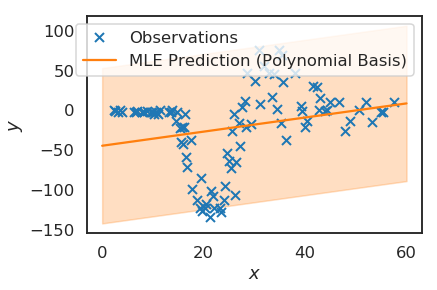

In [8]:
# Let's do it
X_p = np.linspace(0, 60, 100)[:, None]
degree = 1
phi = PolynomialBasis(degree)
Phi = compute_design_matrix(X, phi)
w_MLE, res_MLE = np.linalg.lstsq(Phi, Y)[0:2] # Note that we
                                              # now also use the second
                                              # output of lstsq...
sigma_MLE = np.sqrt(res_MLE / X.shape[0])
Phi_p = compute_design_matrix(X_p, phi)
Y_p = np.dot(Phi_p, w_MLE)
Y_l = Y_p - 2. * sigma_MLE # Lower predictive bound
Y_u = Y_p + 2. * sigma_MLE # Upper predictive bound
fig, ax = plt.subplots()
ax.plot(X, Y, 'x', markeredgewidth=2, label='Observations')
ax.plot(X_p, Y_p, label='MLE Prediction (Polynomial Basis)')
ax.fill_between(X_p.flatten(), Y_l, Y_u, color=sns.color_palette()[1], alpha=0.25)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc='best');

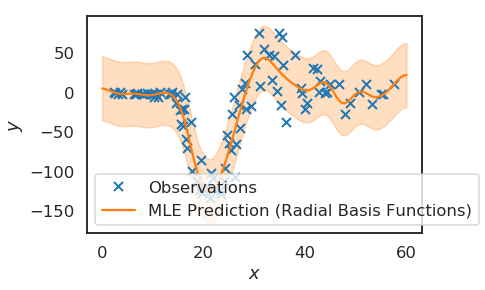

In [9]:
ell = 2.
Xc = np.linspace(0, 60, 20)
phi = RadialBasisFunctions(Xc, ell)
Phi = compute_design_matrix(X, phi)
w_MLE, res_MLE = np.linalg.lstsq(Phi, Y)[0:2] # Note that we
                                              # now also use the second
                                              # output of lstsq...
sigma_MLE = np.sqrt(res_MLE / X.shape[0])
Phi_p = compute_design_matrix(X_p, phi)
Y_p = np.dot(Phi_p, w_MLE)
Y_l = Y_p - 2. * sigma_MLE # Lower predictive bound
Y_u = Y_p + 2. * sigma_MLE # Upper predictive bound
fig, ax = plt.subplots()
ax.plot(X, Y, 'x', markeredgewidth=2, label='Observations')
ax.plot(X_p, Y_p, label='MLE Prediction (Radial Basis Functions)')
ax.fill_between(X_p.flatten(), Y_l, Y_u, color=sns.color_palette()[1], alpha=0.25)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc='best');

### Issues with Maximum Likelihood

It has addressed the issue of uncertainty due to the noise in the data (somewhat, will improve upon later). However it still leaves open the following:
+ How do I quantify uncertainty due to limited data?
+ How many basis functions should I use?
+ Which basis functions should I use?
+ How do I pick the parameters of the basis functions, e.g., the lengthscale $\ell$ of the RBFs?

## Probabilistic Regression - Version 2
+ We wish to model the data using some **fixed** basis/features:
$$
y(\mathbf{x};\mathbf{w}) = \sum_{j=1}^{m} w_{j}\phi_{j}(\mathbf{x}) = \mathbf{w^{T}\boldsymbol{\phi}(\mathbf{x})
}
$$

+ We *model the measurement process* using a **likelihood** function:
$$
\mathbf{y}_{1:n} | \mathbf{x}_{1:n}, \mathbf{w} \sim p(\mathbf{y}_{1:n}|\mathbf{x}_{1:n}, \mathbf{w}).
$$

+ We *model the uncertainty in the model parameters* using a **prior**:
$$
\mathbf{w} \sim p(\mathbf{w}).
$$

### Gaussian Prior on the Weights
+ Consider the following **prior** on $\mathbf{w}$:
$$
p(\mathbf{w}|\alpha) = \mathcal{N}\left(\mathbf{w}|\mathbf{0},\alpha^{-1}\mathbf{I}\right) = 
\left(\frac{\alpha}{2\pi}\right)^{\frac{m}{2}}\exp\left\{-\frac{\alpha}{2}\lVert\mathbf{w}\rVert^2\right\}.
$$
+ We say:

> Before we see the data, we beleive that $\mathbf{w}$ must be around zero with a precision of $\alpha$.

### The Posterior of the Weights
+ Combining the likelihood and the prior, we get using Bayes rule:
$$
p(\mathbf{w}|\mathbf{x}_{1:n},\mathbf{y}_{1:n}, \sigma,\alpha) = 
\frac{p(\mathbf{y}_{1:n}|\mathbf{x}_{1:n}, \mathbf{w}, \sigma)p(\mathbf{w}|\alpha)}
{\int p(\mathbf{y}_{1:n}|\mathbf{x}_{1:n}, \mathbf{w}', \sigma)p(\mathbf{w}'|\alpha)d\mathbf{w}'}.
$$
+ We say
> The posterior summarizes our state of knowledge about $\mathbf{w}$ after we see the data,
if we know $\alpha$ and $\sigma$.

### Maximum Posterior Estimate
+ We can find a point estimate of $\mathbf{w}$ by solving:
$$
\mathbf{w}_{\mbox{MPE}} = \arg\max_{\mathbf{w}} p(\mathbf{y}_{1:n}|\mathbf{x}_{1:n}, \mathbf{w}, \sigma)p(\mathbf{w}|\alpha).
$$
+ For Gaussian likelihood and weights:
$$
\log p(\mathbf{w}|\mathbf{x}_{1:n},\mathbf{y}_{1:n}, \sigma,\alpha) = 
- \frac{1}{2\sigma^2}\lVert\mathbf{\Phi}\mathbf{w}-\mathbf{y}_{1:n}\rVert^2 -\frac{\alpha}{2}\lVert\mathbf{w}\rVert^2.
$$
+ With maximum:
$$
\mathbf{w}_{\mbox{MPE}} = \left(\sigma^{-2}\mathbf{\Phi}^T\mathbf{\Phi}+\alpha\mathbf{I}\right)^{-1}\mathbf{\Phi}^T\mathbf{y}_{1:n}.
$$
+ But, no analytic formula for $\sigma$...

w_MPE:
[  -0.34092858   -1.68904678   -3.19193641   -5.32186481  -18.32277585
 -100.03625967 -216.35332988 -241.24155683 -165.12418937  -26.36065749
   51.58925071   52.3753626    17.89682441    9.91868847    9.65346397
   -3.58400667   -3.22118958   -2.04465552    0.77592555    0.97107365]


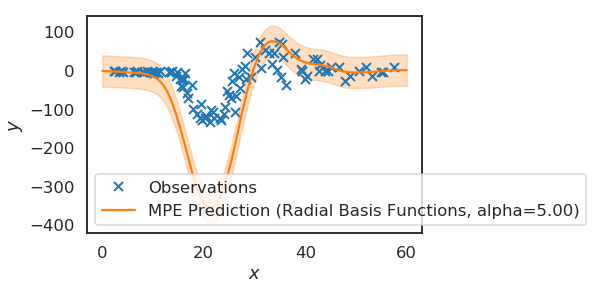

In [10]:
import scipy.linalg
ell = 2.
alpha = 5
sigma = 20.28
Xc = np.linspace(0, 60, 20)
phi = RadialBasisFunctions(Xc, ell)
Phi = compute_design_matrix(X, phi)
A = np.dot(Phi.T, Phi) / sigma ** 2. + alpha * np.eye(Phi.shape[1])
L = scipy.linalg.cho_factor(A)
w_MPE = scipy.linalg.cho_solve(L, np.dot(Phi.T, Y))
print 'w_MPE:'
print w_MPE

# Let's predict on these points:
X_p = np.linspace(0, 60, 100)[:, None]
Phi_p = compute_design_matrix(X_p, phi)
Y_p = np.dot(Phi_p, w_MPE)
Y_l = Y_p - 2. * sigma # Lower predictive bound
Y_u = Y_p + 2. * sigma # Upper predictive bound
fig, ax = plt.subplots()
ax.plot(X, Y, 'x', markeredgewidth=2, label='Observations')
ax.plot(X_p, Y_p, label='MPE Prediction (Radial Basis Functions, alpha=%1.2f)' % alpha)
ax.fill_between(X_p.flatten(), Y_l, Y_u, color=sns.color_palette()[1], alpha=0.25)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc='best');

### Issues with Maximum Posterior Estimate

It doesn't actually do much for us...

+ How do I quantify uncertainty due to limited data?
+ How many basis functions should I use?
+ Which basis functions should I use?
+ How do I pick the parameters of the basis functions, e.g., the lengthscale $\ell$ of the RBFs?

## Probabilistic Regression - Version 3 - Bayesian Linear Regression
+ For Gaussian likelihood and weights, the posterior is Gaussian:
$$
p(\mathbf{w}|\mathbf{x}_{1:n},\mathbf{y}_{1:n}, \sigma, \alpha) = \mathcal{N}\left(\mathbf{w}|\mathbf{m}, \mathbf{S}\right),
$$
where
$$
\mathbf{S} = \left(\sigma^{-2}\mathbf{\Phi}^T\mathbf{\Phi}+\alpha\mathbf{I}\right)^{-1},
$$
(remember? S is our MAP guess) and
$$
\mathbf{m} = \sigma^{-2}\mathbf{S}\Phi^T\mathbf{y}_{1:n}.
$$
+ In general: [Markov Chain Monte Carlo](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo).

### Posterior Predictive Distribution
+ Using probability theory, we ask: What do we know about $y$ at a new $\mathbf{x}$ after seeing the data.
+ We have using the sum rule:
$$
p(y|\mathbf{x}, \mathbf{x}_{1:n}, \mathbf{y}_{1:n}, \sigma, \alpha) = 
\int p(y | \mathbf{x}, \mathbf{w}, \sigma) p(\mathbf{w}|\mathbf{x}_{1:n}, \mathbf{y}_{1:n},\sigma,\alpha)d\mathbf{w}.
$$
+ For Gaussian likelihood and prior:
$$
p(y|\mathbf{x}, \mathbf{x}_{1:n}, \mathbf{y}_{1:n}, \sigma, \alpha) = \mathcal{N}\left(y|m(\mathbf{x}), s^2(\mathbf{x})\right),
$$
where
$$
m(\mathbf{x}) = \mathbf{m}^T\boldsymbol{\phi}(\mathbf{x})\;\mbox{and}\;s(\mathbf{x}) = \boldsymbol{\phi}(\mathbf{x})^T\mathbf{S}\boldsymbol{\phi}(\mathbf{x}) + \sigma^2.
$$

### Predictive Uncertainty
+ The **predictive uncertainty** is:
$$
s^2(\mathbf{x}) = \boldsymbol{\phi}(\mathbf{x})^T\mathbf{S}\boldsymbol{\phi}(\mathbf{x}) + \sigma^2.
$$
+ $\sigma^2$ corresponds to the measurement noise.
+ $\boldsymbol{\phi}(\mathbf{x})^T\mathbf{S}\boldsymbol{\phi}(\mathbf{x})$ is the epistemic uncertainty induced by limited data.

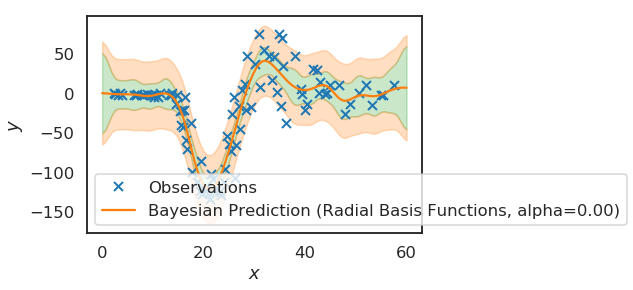

In [11]:
import scipy.linalg
ell = 2.
alpha = 0.001
sigma = 20.28
Xc = np.linspace(0, 60, 20)
phi = RadialBasisFunctions(Xc, ell)
Phi = compute_design_matrix(X, phi)
A = np.dot(Phi.T, Phi) / sigma ** 2. + alpha * np.eye(Phi.shape[1])
L = scipy.linalg.cho_factor(A)
m = scipy.linalg.cho_solve(L, np.dot(Phi.T, Y) / sigma ** 2)  # The posterior mean of w
S = scipy.linalg.cho_solve(L, np.eye(Phi.shape[1]))           # The posterior covariance of w
Phi_p = compute_design_matrix(X_p, phi)
Y_p = np.dot(Phi_p, m) # The mean prediction
V_p_ep = np.einsum('ij,jk,ik->i', Phi_p, S, Phi_p) # The epistemic uncertainty
S_p_ep = np.sqrt(V_p_ep)
V_p = V_p_ep + sigma ** 2 # Full uncertainty
S_p = np.sqrt(V_p)
Y_l_ep = Y_p - 2. * S_p_ep  # Lower epistemic predictive bound
Y_u_ep = Y_p + 2. * S_p_ep  # Upper epistemic predictive bound
Y_l = Y_p - 2. * S_p # Lower predictive bound
Y_u = Y_p + 2. * S_p # Upper predictive bound

fig, ax = plt.subplots()
ax.plot(X, Y, 'x', markeredgewidth=2, label='Observations')
ax.plot(X_p, Y_p, label='Bayesian Prediction (Radial Basis Functions, alpha=%1.2f)' % alpha)
ax.fill_between(X_p.flatten(), Y_l_ep, Y_u_ep, color=sns.color_palette()[2], alpha=0.25)
ax.fill_between(X_p.flatten(), Y_l, Y_l_ep, color=sns.color_palette()[1], alpha=0.25)
ax.fill_between(X_p.flatten(), Y_u_ep, Y_u, color=sns.color_palette()[1], alpha=0.25)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc='best');

### Sampling Posterior Models
+ We can actually sample models (functions) from the posterior. Here is how:
    + Sample a $\mathbf{w}$ from $p(\mathbf{w}|\mathbf{x}_{1:n},\mathbf{y}_{1:n}, \sigma, \alpha)$.
    + Look at the sampled model:
    $$
    y(\mathbf{x};\mathbf{w}) = \mathbf{w}^T\boldsymbol{\phi}(\mathbf{x}).
    $$

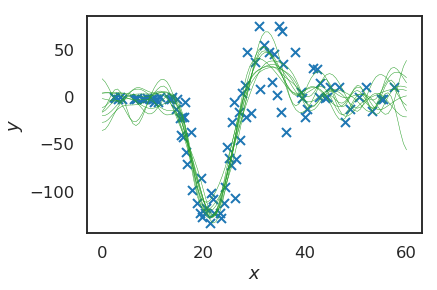

In [12]:
# We have m, S, X_p, and Phi_p from before
fig, ax = plt.subplots()
ax.plot(X, Y, 'x', markeredgewidth=2, label='Observations')
for i in xrange(10):
    w = np.random.multivariate_normal(m, S)
    Y_p_s = np.dot(Phi_p, w)
    ax.plot(X_p, Y_p_s, color=sns.color_palette()[2], linewidth=0.5);
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

### Issues with Bayesian Linear Regression

This has solved one major issue, as it rigorously quantifies the uncertainty due to limited points!

+ How many basis functions should I use?
+ Which basis functions should I use?
+ How do I pick the parameters of the basis functions, e.g., the lengthscale $\ell$ of the RBFs, $\alpha$, etc.?+

## Probabilistic Regression - Version 4 - Hierarchical Priors
+ So, how do we find all the parameters like $\sigma$, $\alpha$, $\ell$, etc?
+ These are all called **hyper-parameters** of the model.
+ Call all of them
$$
\boldsymbol{\theta} = \{\sigma, \alpha, \ell,\dots\}.
$$

### Hierarchical Priors
+ Model:
$$
y(\mathbf{x};\mathbf{w}) = \sum_{j=1}^{m} w_{j}\phi_{j}(\mathbf{x}) = \mathbf{w^{T}\boldsymbol{\phi}(\mathbf{x})}
$$
+ Likelihood:
$$
\mathbf{y}_{1:n} | \mathbf{x}_{1:n}, \mathbf{w}, \boldsymbol{\theta} \sim p(\mathbf{y}_{1:n}|\mathbf{x}_{1:n}, \mathbf{w}, \boldsymbol{\theta}).
$$
+ Weight prior:
$$
\mathbf{w} | \boldsymbol{\theta} \sim p(\mathbf{w}| \boldsymbol{\theta}).
$$
+ Hyper-prior:
$$
\boldsymbol{\theta} \sim p(\boldsymbol{\theta}).
$$

### Fully Bayesian Solution
+ Just write down the posterior of everything:
$$
p(\mathbf{w}, \boldsymbol{\theta}|\mathbf{x}_{1:n}, \mathbf{y}_{1:n}) \propto p(\mathbf{y}_{1:n}|\mathbf{x}_{1:n}|\mathbf{w},\boldsymbol{\theta})p(\mathbf{w}|\boldsymbol{\theta})p(\boldsymbol{\theta}).
$$
+ and, somehow, sample from it...

### The Evidence Approximation
+ Look at the marginal posterior of $\boldsymbol{\theta}$:
$$
p(\boldsymbol{\theta}|\mathbf{x}_{1:n}, \mathbf{y}_{1:n}) \propto 
\int p(\mathbf{y}_{1:n}|\mathbf{x}_{1:n}|\mathbf{w},\boldsymbol{\theta})p(\mathbf{w}|\boldsymbol{\theta})p(\boldsymbol{\theta})d\mathbf{w}.
$$

+ Assume that the hyper-prior is relatively flat:
$$
p(\boldsymbol{\theta}) \propto 1,
$$

+ Use a MAP estimate for $\boldsymbol{\theta}$:
$$
\boldsymbol{\theta}_{\mbox{EV}} = \arg\max_{\boldsymbol{\theta}}\int p(\mathbf{y}_{1:n}|\mathbf{x}_{1:n}|\mathbf{w},\boldsymbol{\theta})p(\mathbf{w}|\boldsymbol{\theta})d\mathbf{w}.
$$

+ Analytical for Gaussian likelihood and prior.

### (FROM HIS NOTES) Implementation Evidence Approximation
+ There is a fast algorithm for the evidence approximation for Bayesian linear regression.
+ It would take about an hour to go over it. See Ch. 3 of (Bishop, 2006).
+ We will use the implementation found in [scikit-learn](http://scikit-learn.org).
+ If you don't have it:
```
conda install scikit-learn
```

best sigma: 22.2067820906
best alpha: 0.00249087490343


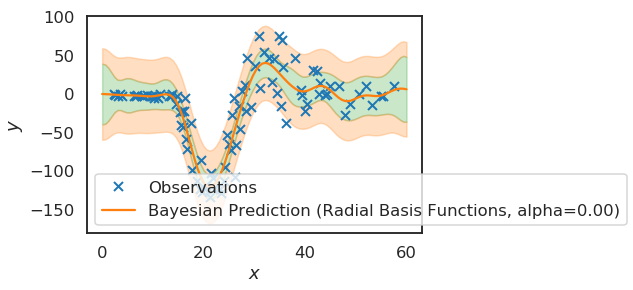

In [13]:
from sklearn.linear_model import BayesianRidge
ell = 2.
Xc = np.linspace(0, 60, 50)
phi = RadialBasisFunctions(Xc, ell)
Phi = compute_design_matrix(X, phi)
regressor = BayesianRidge()
regressor.fit(Phi, Y)
# They are using different names:
sigma = np.sqrt(1. / regressor.alpha_)
print 'best sigma:', sigma
alpha = regressor.lambda_
print 'best alpha:', alpha
A = np.dot(Phi.T, Phi) / sigma ** 2. + alpha * np.eye(Phi.shape[1])
L = scipy.linalg.cho_factor(A)
m = scipy.linalg.cho_solve(L, np.dot(Phi.T, Y) / sigma ** 2)  # The posterior mean of w
S = scipy.linalg.cho_solve(L, np.eye(Phi.shape[1]))           # The posterior covariance of w
Phi_p = compute_design_matrix(X_p, phi)
Y_p = np.dot(Phi_p, m) # The mean prediction
V_p_ep = np.einsum('ij,jk,ik->i', Phi_p, S, Phi_p) # The epistemic uncertainty
S_p_ep = np.sqrt(V_p_ep)
V_p = V_p_ep + sigma ** 2 # Full uncertainty
S_p = np.sqrt(V_p)
Y_l_ep = Y_p - 2. * S_p_ep  # Lower epistemic predictive bound
Y_u_ep = Y_p + 2. * S_p_ep  # Upper epistemic predictive bound
Y_l = Y_p - 2. * S_p # Lower predictive bound
Y_u = Y_p + 2. * S_p # Upper predictive bound

fig, ax = plt.subplots()
ax.plot(X, Y, 'x', markeredgewidth=2, label='Observations')
ax.plot(X_p, Y_p, label='Bayesian Prediction (Radial Basis Functions, alpha=%1.2f)' % alpha)
ax.fill_between(X_p.flatten(), Y_l_ep, Y_u_ep, color=sns.color_palette()[2], alpha=0.25)
ax.fill_between(X_p.flatten(), Y_l, Y_l_ep, color=sns.color_palette()[1], alpha=0.25)
ax.fill_between(X_p.flatten(), Y_u_ep, Y_u, color=sns.color_palette()[1], alpha=0.25)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc='best');

### Issues with Bayesian Linear Regression

This has solved the issue for selecting the hyper parameters!

+ How many basis functions should I use?
+ Which basis functions should I use?

## Probabilistic Regression - Version 5 - Automatic Relevance Determination
+ Use a different precision $\alpha_i$ for each weight:
$$
p(w_j | \alpha_j) \propto \exp\left\{-\alpha_jw_j^2\right\},
$$
+ so that:
$$
p(\mathbf{w}|\boldsymbol{\alpha}) = \propto \prod_{j=1}^mp(w_j|\alpha_j).
$$
+ Then maximize the **evidence** with respect to all the $\alpha_j$'s.
+ **Sparsity**: When $\alpha_j\rightarrow\infty$, $w_j=0$ identically!

best sigma: 21.1802707506
best alpha: [  2.41622694e+01   4.60393723e+01   6.32601940e+01   6.60248705e+01
   6.07577537e+01   6.30419345e+01   6.87983839e+01   7.19885330e+01
   7.47478678e+01   7.18452626e+01   6.67773828e+01   7.04574032e+01
   7.24203099e+01   6.04550341e+01   3.55032689e+01   1.10968067e-03
   1.73367476e-04   1.99589349e+01   2.04616910e+01   1.05969545e-04
   1.86715292e-02   3.14937763e+00   3.87600506e+01   6.61116485e+01
   6.07405331e+01   3.38580108e+01   1.66337169e-03   9.09294119e-04
   2.65807248e+01   3.21594802e+01   2.33882525e+01   3.57257599e+01
   5.45115686e+01   5.24922174e+01   2.87934486e+01   9.11413331e-03
   3.73413978e+01   5.18181885e+01   5.04733546e+01   3.90117514e+01
   3.50099821e+01   4.39235876e+01   4.94959003e+01   5.09197345e+01
   5.16755294e+01   5.22603627e+01   4.72226269e+01   3.69312958e+01
   2.53199918e+01   1.38991944e+01]


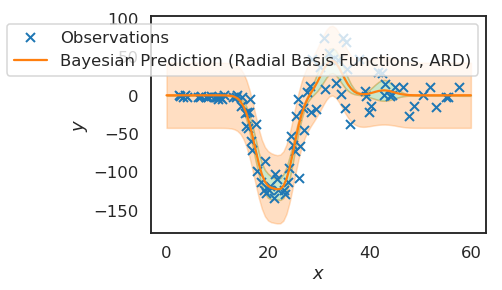

In [14]:
from sklearn.linear_model import ARDRegression
ell = 2.
Xc = np.linspace(0, 60, 50)
phi = RadialBasisFunctions(Xc, ell)
Phi = compute_design_matrix(X, phi)
regressor = ARDRegression()
regressor.fit(Phi, Y)
# They are using different names:
sigma = np.sqrt(1. / regressor.alpha_)
print 'best sigma:', sigma
alpha = regressor.lambda_
print 'best alpha:', alpha
A = np.dot(Phi.T, Phi) / sigma ** 2. + alpha * np.eye(Phi.shape[1])
L = scipy.linalg.cho_factor(A)
m = scipy.linalg.cho_solve(L, np.dot(Phi.T, Y) / sigma ** 2)  # The posterior mean of w
S = scipy.linalg.cho_solve(L, np.eye(Phi.shape[1]))           # The posterior covariance of w
Phi_p = compute_design_matrix(X_p, phi)
Y_p = np.dot(Phi_p, m) # The mean prediction
V_p_ep = np.einsum('ij,jk,ik->i', Phi_p, S, Phi_p) # The epistemic uncertainty
S_p_ep = np.sqrt(V_p_ep)
V_p = V_p_ep + sigma ** 2 # Full uncertainty
S_p = np.sqrt(V_p)
Y_l_ep = Y_p - 2. * S_p_ep  # Lower epistemic predictive bound
Y_u_ep = Y_p + 2. * S_p_ep  # Upper epistemic predictive bound
Y_l = Y_p - 2. * S_p # Lower predictive bound
Y_u = Y_p + 2. * S_p # Upper predictive bound

fig, ax = plt.subplots()
ax.plot(X, Y, 'x', markeredgewidth=2, label='Observations')
ax.plot(X_p, Y_p, label='Bayesian Prediction (Radial Basis Functions, ARD)')
ax.fill_between(X_p.flatten(), Y_l_ep, Y_u_ep, color=sns.color_palette()[2], alpha=0.25)
ax.fill_between(X_p.flatten(), Y_l, Y_l_ep, color=sns.color_palette()[1], alpha=0.25)
ax.fill_between(X_p.flatten(), Y_u_ep, Y_u, color=sns.color_palette()[1], alpha=0.25)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc='best');

This has solved all of the problems we have started with. By using independent alphas for each basis function, you can "propose" any number of basis functions for your model, and Bayesian Linear Regression will automatically filter out the functions that are not needed.